In [2]:
!pip install datasets

!pip install ucimlrepo

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from skimage import io
import cv2
from datasets import load_dataset
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

# 1. Зниження розмірності і візуалізація даних
## Застосуйте методи зниження розмірності sklearn.decomposition.PCA і sklearn.manifold.TSNE для візуалізації даних, з якими ви працювали в лабораторній № 1 (знижуючи розмірність до двох). Візуалізуйте результат.

In [11]:
# fetch dataset
maternal_health_risk = fetch_ucirepo(id=863)
# data (as pandas dataframes)
X = maternal_health_risk.data.features
print(X)
Y = maternal_health_risk.data.targets
if isinstance(Y, pd.DataFrame):
    Y = Y.iloc[:, 0]  # Convert DataFrame to Series by selecting the first column

# Create a mapping dictionary to convert categorical risk levels into numerical values
# 'low risk' -> 0, 'mid risk' -> 0.5, 'high risk' -> 1
risk_mapping = {'low risk': 0, 'mid risk': 0.5, 'high risk': 1}
# Apply the mapping to the target variable Y, replacing categorical values with the corresponding numerical values
Y_encoded = Y.map(risk_mapping)  # Y is a Series
print(Y_encoded)

      Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
0      25         130           80  15.0      98.0         86
1      35         140           90  13.0      98.0         70
2      29          90           70   8.0     100.0         80
3      30         140           85   7.0      98.0         70
4      35         120           60   6.1      98.0         76
...   ...         ...          ...   ...       ...        ...
1009   22         120           60  15.0      98.0         80
1010   55         120           90  18.0      98.0         60
1011   35          85           60  19.0      98.0         86
1012   43         120           90  18.0      98.0         70
1013   32         120           65   6.0     101.0         76

[1014 rows x 6 columns]
0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
1009    1.0
1010    1.0
1011    1.0
1012    1.0
1013    0.5
Name: RiskLevel, Length: 1014, dtype: float64


### РСА

Використовує лінійний підхід для зниження розмірності, намагаючись знайти основні компоненти, які максимізують варіацію даних. Це означає, що PCA зберігає лінійні відносини між ознаками.

[2 2 2 ... 2 2 1]


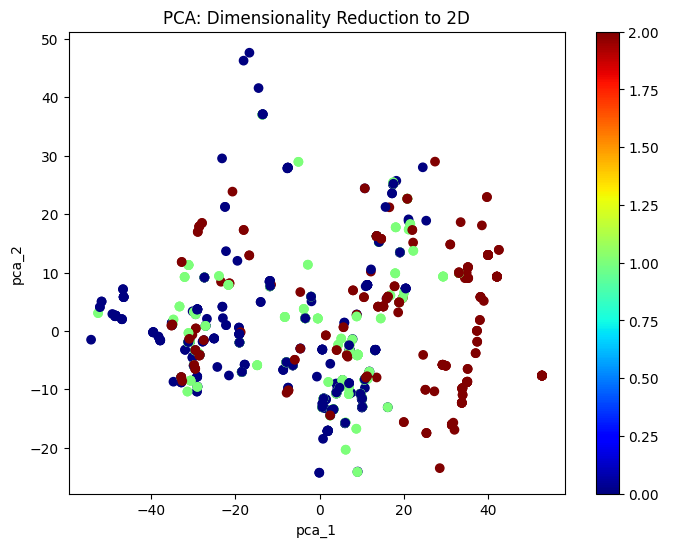

In [14]:
# Using PCA to reduce dimensionality to two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Encode class labels into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y_encoded.values.ravel())
print(y_encoded)

# PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='jet')
plt.title('PCA: Dimensionality Reduction to 2D')
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.colorbar(label=' ')
plt.show()


### t-SNE

Це нелінійний метод, який створює ймовірнісні розподіли для сусідніх точок у високій розмірності і намагається зберегти ці ймовірнісні відносини в низькій розмірності. Це дозволяє краще візуалізувати локальні структури даних.

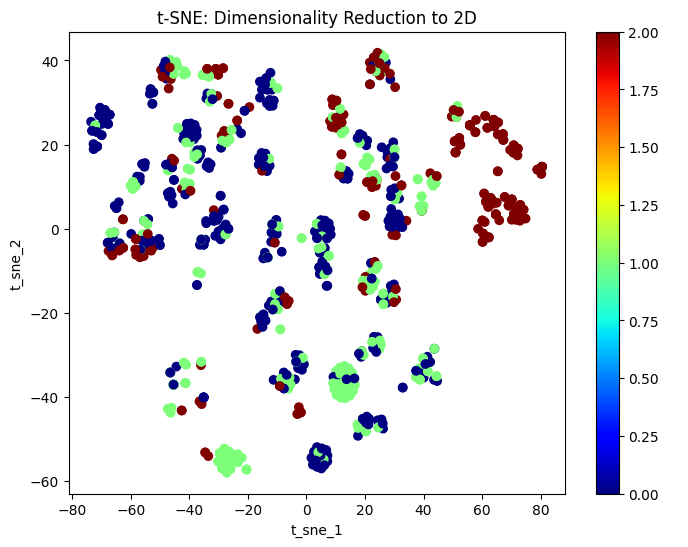

In [15]:
# Using t-SNE to reduce dimensionality to two components
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='jet')
plt.title('t-SNE: Dimensionality Reduction to 2D')
plt.xlabel('t_sne_1')
plt.ylabel('t_sne_2')
plt.colorbar(label=' ')
plt.show()


# 2. Кластерний аналіз
## За допомогою алгоритму k-means зробіть квантування зображення (видалення візуально надлишкової інформації) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення.


 Пікселі кластеризуються на основі схожості кольорів, і кожен кластер замінюється своїм центроїдом. *Він намагається розділити дані на k кластерів так, щоб кожен елемент належав до кластера з найближчим середнім значенням. Алгоритм працює ітеративно та мінімізує внутрішньокластерні відстані, обчислюючи нові центроїди для кластерів.*

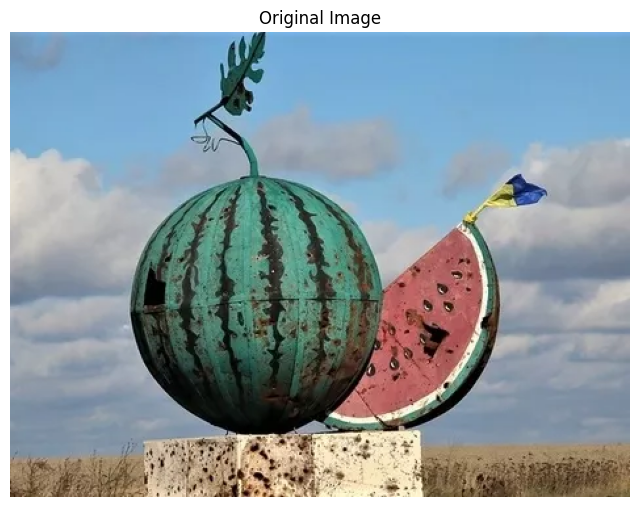

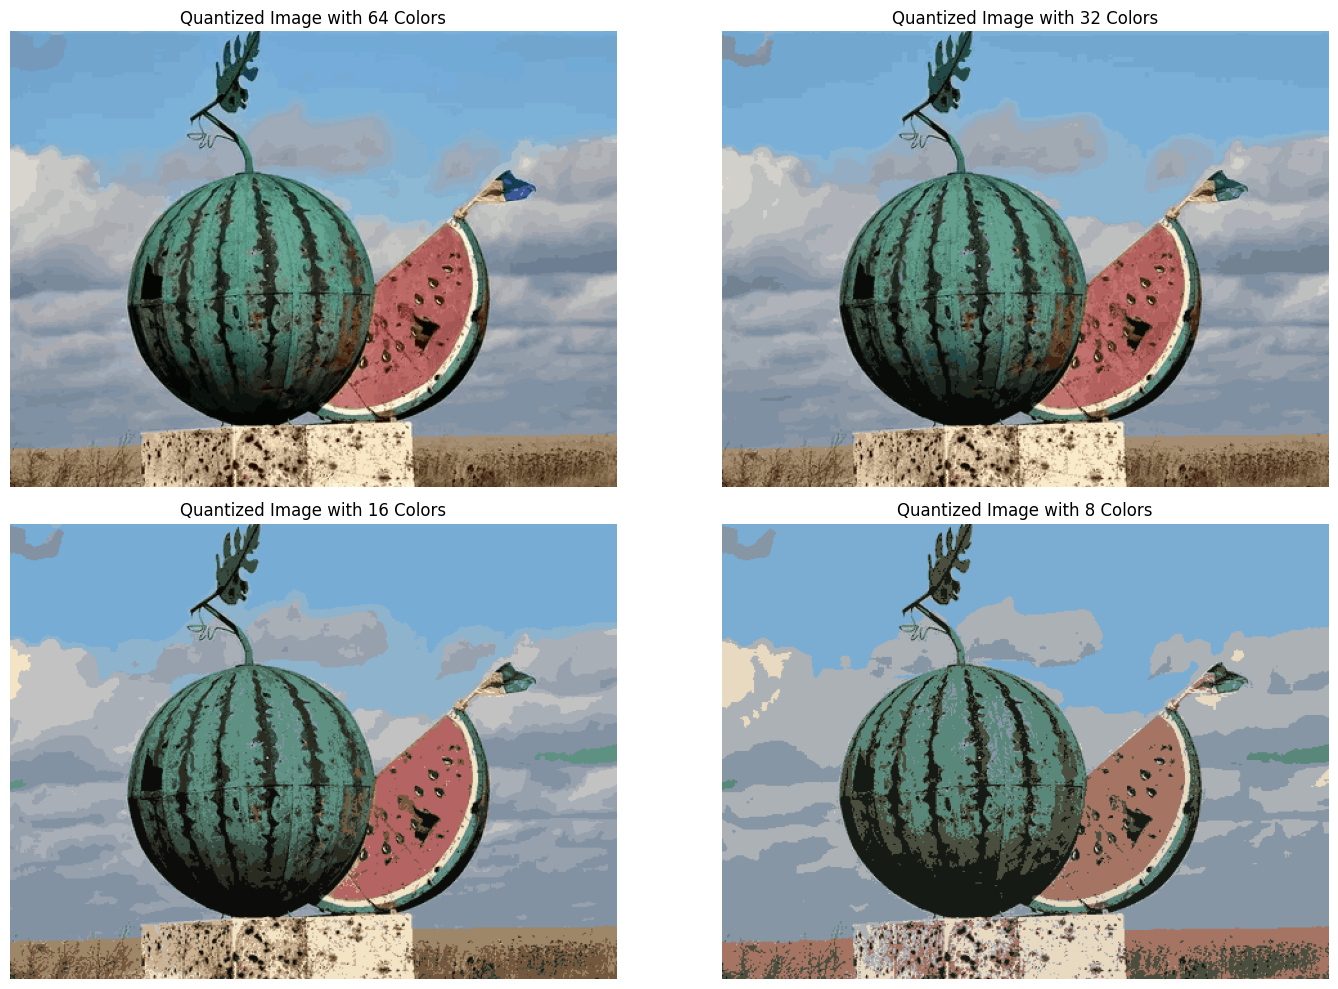

In [16]:
# Load the image
image = io.imread('kherso.jpeg')

# Show the original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Function to quantize the image using k-means
def quantize_image(image, n_colors):
    # Reshape the image to a two-dimensional array (number of pixels, 3)
    pixels = image.reshape(-1, 3)

    # Use k-means to quantize colors
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(pixels)

    # Replace pixel colors with cluster centroids
    new_pixels = kmeans.cluster_centers_[kmeans.labels_].astype(int)

    # Reshape the pixels back to the image shape
    new_image = new_pixels.reshape(image.shape)

    return new_image

# Create a list of quantization levels
levels = [64, 32, 16, 8]

# Visualize the results for different levels
plt.figure(figsize=(15, 10))

for i, level in enumerate(levels):
    quantized_image = quantize_image(image, level)

    # Show the quantized image
    plt.subplot(2, 2, i + 1)
    plt.imshow(quantized_image)
    plt.title(f'Quantized Image with {level} Colors')
    plt.axis('off')

plt.tight_layout()
plt.show()


# 3. Обробка та класифікація текстових даних

## Завантажте набір текстових даних (з мітками класів). Проведіть передобробку даних (видаліть стоп-слова, пунктуацію), за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). Проведіть класифікацію текстових даних, зробіть оцінку якості.

In [4]:
# Load the Yelp Reviews dataset
yelp_reviews = load_dataset("yelp_polarity")

# Convert the training data to a pandas DataFrame
train_df = pd.DataFrame(yelp_reviews['train'])
test_df = pd.DataFrame(yelp_reviews['test'])

# Cut the DataFrame to keep only the first 380000 rows
train_df_cut = train_df.head(380000)

# Convert the training data to a pandas DataFrame
test_df = pd.DataFrame(yelp_reviews['test'])

# Cut the DataFrame to keep only the first 380000 rows
test_df_cut = test_df.head(380000)

print(train_df_cut)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                                     text  label
0       Unfortunately, the frustration of being Dr. Go...      0
1       Been going to Dr. Goldberg for over 10 years. ...      1
2       I don't know what Dr. Goldberg was like before...      0
3       I'm writing this review to give you a heads up...      0
4       All the food is great here. But the best thing...      1
...                                                   ...    ...
379995  Mediocre and I am being kind. Appetizer chips ...      0
379996  Great food and great service.  One of my favor...      1
379997  The food was not good and was exceptionally ov...      0
379998  How can I explain the 3 different waiters we h...      0
379999  If you like waiting 40 mins before getting any...      0

[380000 rows x 2 columns]


 1) Завантажуються стоп-слова з бібліотеки NLTK. Стоп-слова — це часто вживані слова (наприклад, "the", "is", "in"), які не несуть суттєвого значення і зазвичай видаляються з тексту, щоб зосередитися на важливих термінах.

 2) Текст перетворюється у нижній регістр для уникнення дублікації слів (наприклад, "The" і "the" будуть однаковими).

3) Видаляється пунктуацію, що може перешкоджати правильному аналізу тексту.

4) Видаляються стоп-слова

In [5]:
# Load stop words
nltk.download('stopwords')  # Stop words are commonly used words in a language (like "the", "is", "in", etc.)
stop_words = set(stopwords.words('english'))

# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the review texts using .loc to avoid warnings
train_df_cut.loc[:, 'text'] = train_df_cut['text'].apply(preprocess_text)
test_df_cut.loc[:, 'text'] = test_df_cut['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


wordcloud - візуалізація текстових даних, яка відображає найчастіше вживані слова в тексті, де розмір кожного слова пропорційний до його частоти в тексті. Чим частіше слово зустрічається, тим більшим і яскравішим воно виглядає на зображенні.

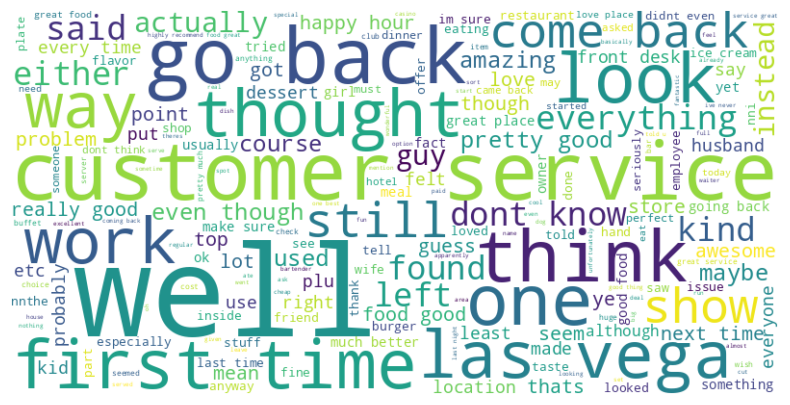

In [7]:


# Generate a word cloud for the training set
text_all = ' '.join(train_df_cut['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

# Visualize the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



TF-IDF — це статистична міра, яка оцінює важливість слова в документі, що належить до колекції або корпусу текстів. Вона складається з двох основних компонентів:

  
*   TF вимірює частоту терміна (слова) в документі. Чим більше разів слово з'являється в документі, тим вища його частота.


*     IDF оцінює важливість терміна в усьому корпусі. Слова, які зустрічаються у багатьох документах, отримують меншу вагу, тоді як рідкісні слова отримують вищу вагу.




In [8]:

# Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df_cut['text'])
y_train = train_df_cut['label']  # Use the labels directly from the cut DataFrame
X_test = vectorizer.transform(test_df_cut['text'])  # Transform test data using the same vectorizer
y_test = test_df_cut['label']


Логістична регресія використовує логістичну функцію (або сигмоїдальну функцію) для перетворення виходу лінійної комбінації вхідних змінних у ймовірність.

Процес навчання логістичної регресії полягає у знаходженні оптимальних значень коефіцієнтів (вагів). Це зазвичай досягається за допомогою методу максимального правдоподібності, що передбачає максимізацію ймовірності спостереження даних, наданих параметрами моделі.

 Логістична регресія видає ймовірність того, що спостереження належить до класу 1. Якщо ймовірність перевищує певний поріг (зазвичай 0.5), спостереження класифікується як клас 1, інакше — як клас 0.

In [9]:
# Train the logistic regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

print("Number of iterations:", model.n_iter_)

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     19000
           1       0.93      0.93      0.93     19000

    accuracy                           0.93     38000
   macro avg       0.93      0.93      0.93     38000
weighted avg       0.93      0.93      0.93     38000

Number of iterations: [15]
